In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import TypedDict
from pathlib import Path
import pandas as pd
import seaborn as sns

In [17]:
def compute_ensemble_stddev(
    df_preds,
    scorer_name="standard_scorer",
):
    """
    Parameters
    ----------
    df_preds : List[pd.DataFrame]
        model predictions

    Returns
    -------
    np.ndarray
        shape (n_frames, n_keypoints)
    """
    # Initial check for NaNs in df_preds
    for i, df in enumerate(df_preds):
        if df.isna().any().any():
            print(f"Warning: NaN values detected in initial DataFrame {i}.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(
                f"NaN values found at indices: {nan_indices} in columns: {nan_columns}"
            )

    preds = []
    for i, df in enumerate(df_preds):
        # Standardize the 'scorer' level
        df = standardize_scorer_level(df, scorer_name)

        # Remove likelihood columns
        cols_to_keep = [
            col
            for col in df.columns
            if not col[2].endswith("likelihood") and "Unnamed" not in col[2]
        ]
        df = df[cols_to_keep]

        #print(f"DataFrame {i} kept columns:", df.columns)

        # Check for NaNs in the DataFrame
        if df.isna().any().any():
            print(f"Warning: NaN values detected in DataFrame {i} after filtering.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(
                f"NaN values found at indices: {nan_indices} in columns: {nan_columns}"
            )

        # Reshape the DataFrame to the appropriate shape
        try:
            arr = df.to_numpy().reshape(df.shape[0], -1, 2)
        except ValueError as e:
            print(f"Reshape error: {e}")
            print(f"DataFrame shape: {df.shape}")
            print(f"Array shape after reshape attempt: {df.to_numpy().shape}")
            raise

        preds.append(arr[..., None])

    preds = np.concatenate(preds, axis=3)

    # Check for NaNs in preds
    if np.isnan(preds).any():
        print("Warning: NaN values detected in preds array.")
        nan_indices = np.argwhere(np.isnan(preds))
        print(f"NaN values found at indices: {nan_indices}")
    else:
        print("No NaN values detected in preds array.")

    stddevs = np.std(preds, axis=-1).mean(axis=-1)
    print(f"Stddevs: {stddevs}")
    return stddevs


def standardize_scorer_level(df, new_scorer="standard_scorer"):
    """
    Standardizes the 'scorer' level in the MultiIndex to a common name.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to standardize.
    new_scorer : str
        The new name for the 'scorer' level.

    Returns
    -------
    pd.DataFrame
        The DataFrame with the standardized 'scorer' level.
    """
    df.columns = pd.MultiIndex.from_tuples(
        [(new_scorer, bodypart, coord) for scorer, bodypart, coord in df.columns],
        names=df.columns.names,
    )
    return df


def compute_percentiles(arr, std_vals, percentiles):
    num_pts = arr[0]
    vals = []
    prctiles = []
    for p in percentiles:
        v = num_pts * p / 100
        idx = np.argmin(np.abs(arr - v))
        # maybe we don't have enough data
        if idx == len(arr) - 1:
            p_ = arr[idx] / num_pts * 100
        else:
            p_ = p
        vals.append(std_vals[idx])
        prctiles.append(np.round(p_, 2))
    return vals, prctiles


class Ensemble:
    data_to_plot: dict[str, str]  # Model name to path.
    pred_csv_list: list[str]
    error_csv_list: list[str]
    df_pred_list: list[pd.DataFrame]
    df_error_list: list[pd.DataFrame]
    n_points_dict: dict[str, dict[str, int]]  # Model name -> std_val_inx -> num points
    std_vals: list[float]
    df_w_vars: pd.DataFrame
    df_line2: pd.DataFrame

# output_dir = "/home/ks3582/synced/outputs/chickadee/cropzoom/"
output_dir = "~/synced/lightning-pose/outputs/chickadee/cropzoom/"
ind = Ensemble()
ind.data_to_plot = {}
for i in range(5):
    key = f"v0.{i}.0"
    value = output_dir + f"detector_{i}/image_preds/CollectedData_merged.csv/predictions.csv"
    ind.data_to_plot[key] = value

    key = f"v1.{i}.0"
    value = output_dir + f"pose_supervised_{i}/image_preds/cropped_CollectedData_merged.csv/remapped_predictions.csv"
    ind.data_to_plot[key] = value

    key = f"v2.{i}.0"
    value = output_dir + f"pose_ctx_{i}/image_preds/cropped_CollectedData_merged.csv/remapped_predictions.csv"
    ind.data_to_plot[key] = value

ood = Ensemble()
ood.data_to_plot = {}
for i in range(5):
    key = f"v0.{i}.1"
    value = output_dir + f"detector_{i}/image_preds/CollectedData_merged_new.csv/predictions.csv"
    ood.data_to_plot[key] = value

    key = f"v1.{i}.1"
    value = output_dir + f"pose_supervised_{i}/image_preds/cropped_CollectedData_merged_new.csv/remapped_predictions.csv"
    ood.data_to_plot[key] = value

    key = f"v2.{i}.1"
    value = output_dir + f"pose_ctx_{i}/image_preds/cropped_CollectedData_merged_new.csv/remapped_predictions.csv"
    ood.data_to_plot[key] = value

In [18]:
def build_ensemble(ens: Ensemble):
    data_to_plot = ens.data_to_plot
    # define predictions so we can compute ensemble variance
    pred_csv_list = []
    # define model names
    model_names_list = []
    # reformat
    for key, val in data_to_plot.items():
        model_names_list.append(key)
        pred_csv_list.append(Path(val))

    error_csv_list = []
    for p in pred_csv_list:
        p = p.with_stem(p.stem.replace("remapped_", "") + "_pixel_error")
        error_csv_list.append(p)

    # load data
    df_pred_list = []
    df_error_list = []
    for pred_csv, error_csv in zip(pred_csv_list, error_csv_list):
        preds_df = pd.read_csv(pred_csv, header=[0, 1, 2], index_col=0).sort_index()
        df_pred_list.append(preds_df)
        df = pd.read_csv(error_csv, header=[0], index_col=0).sort_index()
        if "set" in df.columns:
            df = df.drop(columns=["set"])
        df_error_list.append(df)

    # compute ensemble variance
    ens_stddev = compute_ensemble_stddev(
        df_pred_list,
    )

    # Record pixel errors along with ensemble variances
    df_w_vars = []
    # Dataframe:
    #   Index = {img_path}_{model_name}_{kp}: str
    #   model: str
    #   keypoint: str
    #   pixel_error: float
    #   ens-std: float

    for df_error, df_pred, model_name in zip(
        df_error_list, df_pred_list, model_names_list
    ):
        # Ensure df_error has the same index as df_gt
        assert (df_error.index == df_pred_list[0].index).all()
        assert (df_pred.index == df_pred_list[0].index).all()

        # Calculate total pixel error (sum) for each df_error and print it
        total_pixel_error = df_error.sum().sum()
        print(f"Total pixel error for model {model_name}: {total_pixel_error}")

        for i, kp in enumerate(df_error.columns):
            index = [f"{i}_{model_name}_{kp}" for i in df_error.index]
            df_w_vars.append(
                pd.DataFrame(
                    {
                        "pixel_error": df_error[kp].values,
                        "likelihood": df_pred.loc[
                            :, ("standard_scorer", kp, "likelihood")
                        ].values,
                        "ens-std": ens_stddev[:, i],
                        "ens-std-prctile": [
                            np.sum(ens_stddev < p) / ens_stddev.size
                            for p in ens_stddev[:, i]
                        ],
                        "ens-std-prctile-kp": [
                            np.sum(ens_stddev[:, i] < p) / ens_stddev[:, i].size
                            for p in ens_stddev[:, i]
                        ],
                        "keypoint": kp,
                        "model": model_name,
                    },
                    index=index,
                )
            )

    df_w_vars = pd.concat(df_w_vars)

    std_vals = np.arange(0, 8, 0.2)

    # Dict from [model_name][std_vals_index] to the number of points for that model that were greater than
    # std_vals[std_vals_index].
    n_points_dict = {m: np.nan * np.zeros_like(std_vals) for m in model_names_list}

    # Like df_w_vars but one per std_val
    # Dataframe:
    #   Index = {img_path}_{model_name}_{kp}_{std_val_index}: str
    #   model: str
    #   keypoint: str
    #   pixel_error: float
    #   ens-std: float
    #   n_points: int
    df_line2 = []

    for s, std in enumerate(std_vals):
        # Get all
        df_tmp_ = df_w_vars[df_w_vars["ens-std"] > std]
        for model_name in model_names_list:
            d = df_tmp_[df_tmp_.model == model_name]
            n_points = np.sum(~d["pixel_error"].isna())
            n_points_dict[model_name][s] = n_points
            index = []
            for row, keypoint in zip(d.index, d["keypoint"].to_numpy()):
                index.append(f"{row}_{s}")

            df_line2.append(
                pd.DataFrame(
                    {
                        "ens-std": std,
                        "model": model_name,
                        "pixel_error": d.pixel_error.to_numpy(),
                        "keypoint": d["keypoint"].to_numpy(),
                    },
                    index=index,
                )
            )

    df_line2 = pd.concat(df_line2)
    ens.pred_csv_list = pred_csv_list
    ens.error_csv_list = error_csv_list
    ens.df_pred_list = df_pred_list
    ens.df_error_list = df_error_list
    ens.n_points_dict = n_points_dict
    ens.std_vals = std_vals
    ens.df_w_vars = df_w_vars
    ens.df_line2 = df_line2
    return ens

In [19]:
build_ensemble(ood)
build_ensemble(ind)

No NaN values detected in preds array.
Stddevs: [[16.67562682 15.92336871 20.76884653 ...  5.30997651  3.86190431
   4.42575121]
 [10.94556834 10.69410247 10.65151435 ...  4.84998217  4.21330401
   4.66156029]
 [ 4.04932017  3.88714144  3.7385381  ... 10.9067417   7.33310057
   6.52528165]
 ...
 [ 4.99900042  5.33968584  2.69612337 ... 12.11197028  6.04371325
   5.85852196]
 [ 4.10622303  4.42981424  4.99641223 ...  5.94982348  7.89563436
  11.23426807]
 [10.22295398 11.47285264  3.85669589 ... 11.73783147  5.95523915
   9.04943312]]
Total pixel error for model v0.0.1: 360455.42273296305
Total pixel error for model v1.0.1: 309067.40741807385
Total pixel error for model v2.0.1: 317671.47168061737
Total pixel error for model v0.1.1: 374877.33987799013
Total pixel error for model v1.1.1: 308791.869496769
Total pixel error for model v2.1.1: 324648.4271439693
Total pixel error for model v0.2.1: 355672.2605598812
Total pixel error for model v1.2.1: 295944.7283319135
Total pixel error for mod

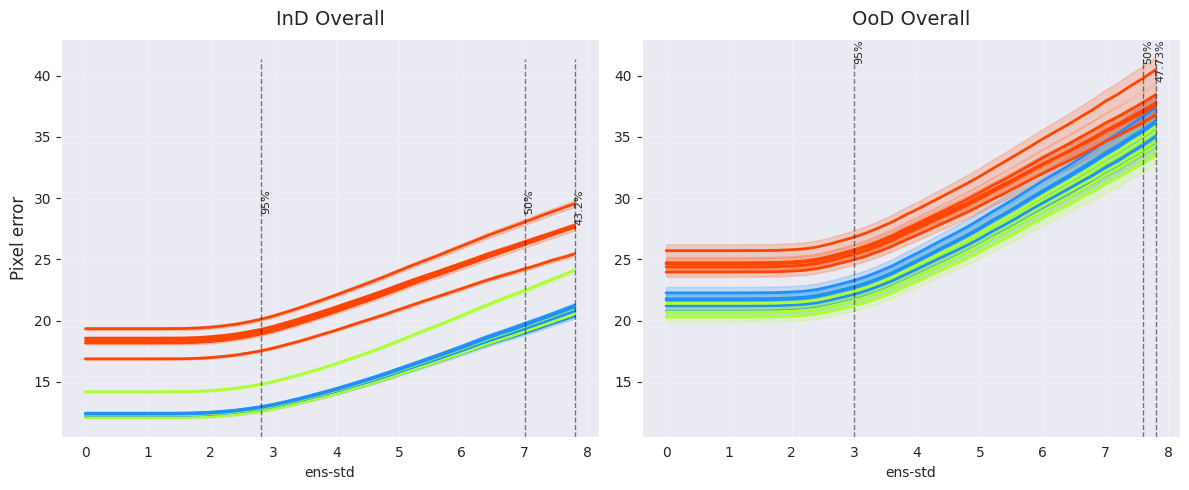

In [22]:
# Define the color mapping
color_mapping = {
    "v0": "#FF4500",  # Orange Red
    "v0e": "#DC143C",  # Crimson
    "v1": "#ADFF2F",  # Green Yellow
    "v1e": "#32CD32",  # Lime Green
    "v2": "#1E90FF",  # Dodger Blue
    "v2e": "#8A2BE2",  # Blue Violet
    "v2s": "#000000",  # Black
    "v24k.0": "#1E90FF",
    "v24k.1": "#1E90FF",
    "v24k.2": "#1E90FF",
    "v24k": "#1E90FF",
    "v25k.0": "#000000",
    "v25k.1": "#000000",
    "v25k.2": "#000000",
    "v25k": "#000000",
    "v25ke": "#FF4500",  # Orange Red
    "v3": "#00CED1",  # Dark Turquoise
    "v3.0": "#00CED1",
    "v3.1": "#00CED1",
    "v3.2": "#00CED1",
    "v3_5k_128.0": "#00CED1",
    "v35k.1": "#00CED1",
    "v35k.2": "#00CED1",
    "v3_5k_128": "#00CED1",
    "v35ke": "#32CD32",  # Lime Green
    "v3_1.5k_128": "#FF4500",  # Orange Red
    "v3_1.5k_256": "#8A2BE2",  # Blue Violet
    "v3_5k_256": "#32CD32",  # Lime Green
    #     'eks': '#FF1493',             # Deep Pink
    #     'network_rng2_in_context': '#FFD700',  # Gold
}
import itertools
for ind_ood, seed, model_type in itertools.product(range(2), range(5), range(3)):
    if model_type == 0:
        color = color_mapping["v0"]
    elif model_type == 1:
        color = color_mapping["v1"]
    else:
        color = color_mapping["v2"]
    color_mapping[f"v{model_type}.{seed}.{ind_ood}"] = color


def plot(ax, models_to_plot, ensName, keypoint=None):
    for model in models_to_plot:

        mask = df_line2["model"] == model
        if keypoint is not None:
            mask = mask & (df_line2["keypoint"] == keypoint)

        data = df_line2[mask]

        sns.lineplot(
            x="ens-std",
            y="pixel_error",
            data=data,
            label=model,
            color=color_mapping[model],
            ax=ax,
            errorbar="se",
            linewidth=2,
        )

    if keypoint is not None:
        ax.set_title(f"{keypoint} {ensName}", fontsize=14, pad=10)
    else:
        ax.set_title(f"{ensName} Overall", fontsize=14, pad=10)

    ax.set_ylabel(f"Pixel error", fontsize=12)
    #ax.set_xlabel("Ensemble std dev", fontsize=12)
    #ax.set_xlabel(, fontsize=12)
    # ax.set_ylim(bottom=0)  # Ensure y-axis starts at 0
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.tick_params(axis='y', labelleft=True, left=True)

    if ax.get_legend() is not None:
        ax.get_legend().set_visible(False)
    #    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8, frameon=False)

    # Plot annotations
    percentiles = [95, 50, 5]
    vals, prctiles = compute_percentiles(
        arr=n_points_dict[models_to_plot[0]],
        std_vals=std_vals,
        percentiles=percentiles,
    )

    for p, v in zip(prctiles, vals):
        ax.axvline(
            v, ymax=0.95, linestyle="--", linewidth=1, color="black", alpha=0.5
        )
        ax.text(
            v,
            ax.get_ylim()[1],
            f"{p}%",
            ha="left",
            va="top",
            fontsize=8,
            rotation=90,
        )

    ax.grid(True, alpha=0.3)



ensembles: list[Ensemble] = [ind, ood]

fig, axes = plt.subplots(
    ncols=len(ensembles),
    nrows=1,
    figsize=(6 * len(ensembles), 5),
    sharey="row",
)
for i, ens in enumerate(ensembles):
    ens: Ensemble
    models_to_plot = list(ens.data_to_plot.keys())
    df_line2 = ens.df_line2
    n_points_dict = ens.n_points_dict
    std_vals = ens.std_vals

    ax = axes[i]
    plot(ax, models_to_plot, "InD" if ens==ind else "OoD")
plt.tight_layout()
plt.autoscale(enable=True, axis='y',)
plt.show()


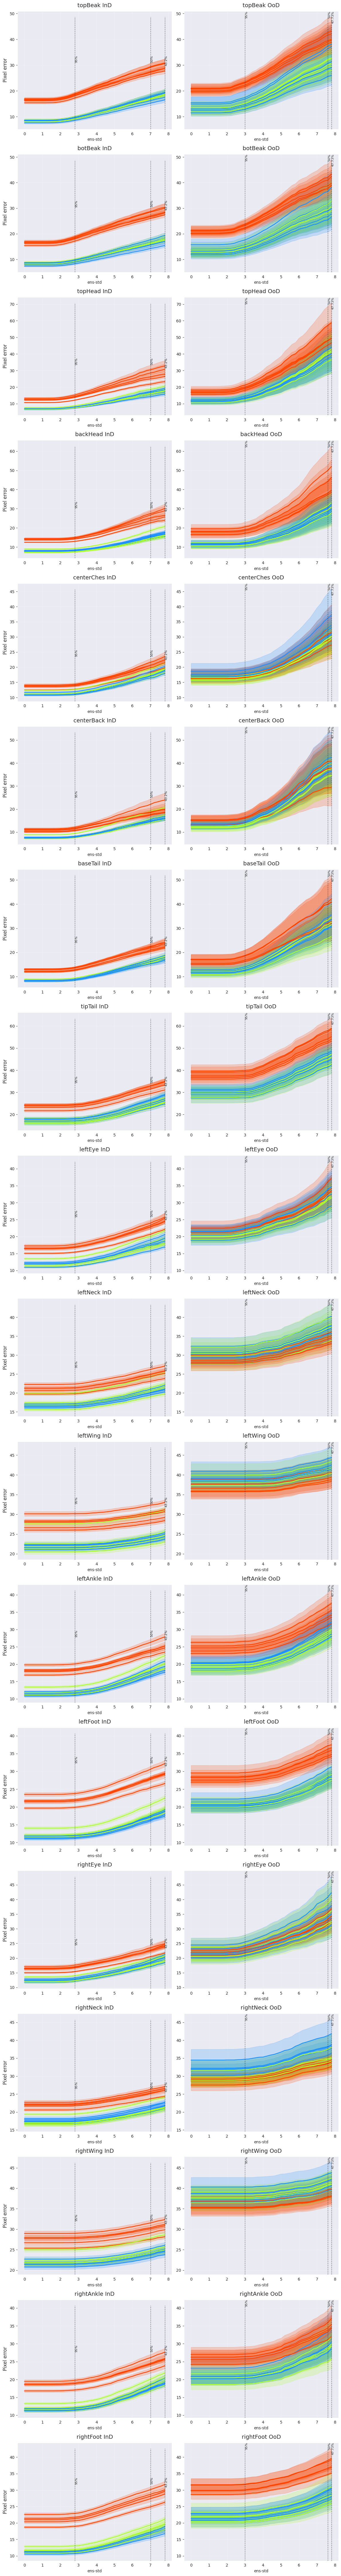

In [23]:

keypoints = ind.df_error_list[0].columns.tolist()
fig, axes = plt.subplots(
    ncols=len(ensembles),
    nrows=len(keypoints),
    figsize=(6 * len(ensembles), 5 * len(keypoints)),
    sharey="row",
)
for i, ens in enumerate(ensembles):
    ens: Ensemble
    models_to_plot = list(ens.data_to_plot.keys())
    df_line2 = ens.df_line2
    n_points_dict = ens.n_points_dict
    std_vals = ens.std_vals

    for j, keypoint in enumerate(keypoints):
        ax = axes[j, i]
        plot(ax, models_to_plot, "InD" if ens==ind else "OoD", keypoint=keypoint)

#plt.subplots_adjust(bottom=0.25, hspace=0.8)
plt.tight_layout()
plt.autoscale(enable=True, axis='y',)
plt.show()